In [1]:
import numpy as np
import pandas as pd
import warnings
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

In [2]:
import pandas as pd
suzuki=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_from_pistachio.csv')

In [3]:
suzuki.head(2)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0,0,1,2,3,4,is_base_template
0,1474,[CH3:1][c:2]1[cH:3][cH:4][c:5]([n:6]1-[c:7]1[c...,US20010007873A1_0204,"EXAMPLE 15, Step D",3.1.5,Bromo Suzuki-type coupling,True
1,1485,[CH3:1][c:2]1[cH:3][cH:4][c:5]([n:6]1-[c:7]1[c...,US20010007873A1_0242,"EXAMPLE 20, Step F",3.1.5,Bromo Suzuki-type coupling,True


In [4]:
#data_test=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/data_with_ASKCOS_score.csv')
data_test=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_with_label_180.csv')

In [5]:
from similarity_v1 import get_rxn_ecfp, get_max_ecfp_dice_similarity

In [6]:
from tqdm import tqdm
tqdm.pandas()

In [7]:
suzuki['ecfp']=suzuki['0'].apply(lambda x: get_rxn_ecfp(x))

In [8]:
data_test['ecfp']=data_test['rxn_smiles_x'].progress_apply(lambda x: get_rxn_ecfp(x))

100%|██████████| 180/180 [00:00<00:00, 4044.50it/s]


In [9]:
emb_list=suzuki['ecfp'].tolist()

In [10]:
data_test['max_ecfp_sim']=data_test['ecfp'].progress_apply(lambda x: get_max_ecfp_dice_similarity(x,emb_list))

100%|██████████| 180/180 [00:36<00:00,  4.87it/s]


In [11]:
data_test['max_ecfp_sim'].describe()

count    180.000000
mean       0.591807
std        0.136874
min        0.379786
25%        0.496887
50%        0.550837
75%        0.654062
max        0.928571
Name: max_ecfp_sim, dtype: float64

##### ROC-AUC

In [12]:
data_test['label_x1'] = data_test['label_x'].replace('S', 'Y')

<Figure size 640x480 with 0 Axes>

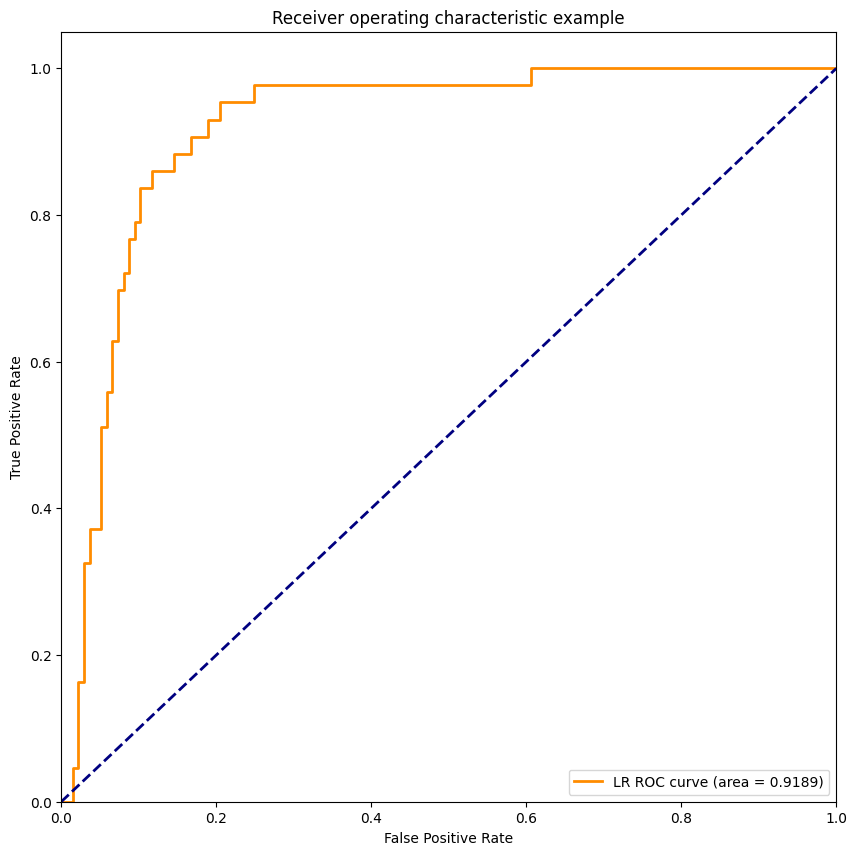

In [14]:
import matplotlib.pyplot as plt
label_dict = {'N': 0, 'Y': 1}
y_true = data_test['label_x1'].map(label_dict).values
y_scores = data_test['max_ecfp_sim'].values
from sklearn import metrics
fpr,tpr,thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)  # 计算auc的值

# 绘制roc曲线
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',lw=lw,label='LR ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#data_test.to_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_with_label_180_with_sim.csv',index=False)

##### correlation analysis

/tmp/ipykernel_1879873/1146818578.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_test.groupby(['sim_range', 'label_x1']).size().unstack()


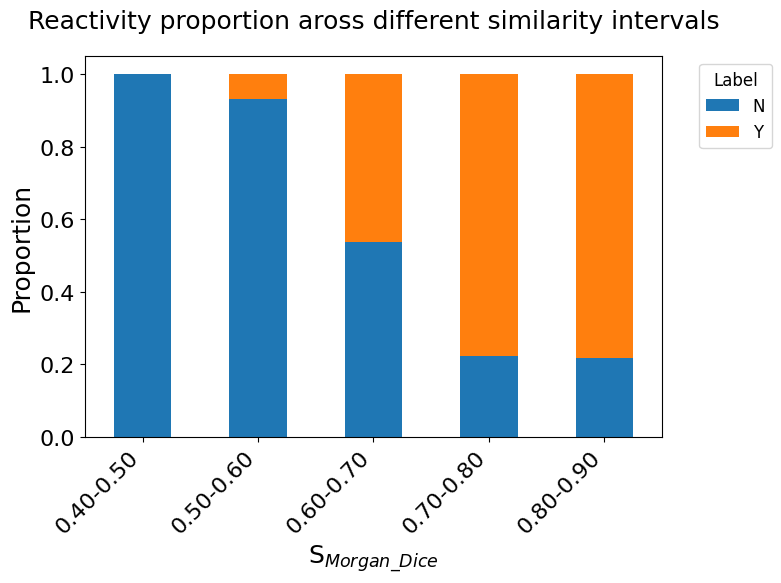

In [15]:
import matplotlib.pyplot as plt
bins = [0.40,0.50, 0.60, 0.70, 0.80, 0.90]
labels = ['0.40-0.50','0.50-0.60', '0.60-0.70','0.70-0.80', '0.80-0.90']
data_test['sim_range'] = pd.cut(data_test['max_ecfp_sim'], bins=bins, labels=labels)
grouped = data_test.groupby(['sim_range', 'label_x1']).size().unstack()

# 计算每个分组中 Y、S 和 N 的数量，并计算比例
total = grouped.sum(axis=1)
proportions = grouped.apply(lambda x: x / total)

# 设置图表大小和字体大小
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 12

# 绘制堆叠条形图
ax = proportions.plot(kind='bar', stacked=True)

# 设置标题、标签和图例
ax.set_title('Reactivity proportion aross different similarity intervals',fontsize=18,pad=20)
ax.set_xlabel('S$_{Morgan\_Dice}$',fontsize=18)
ax.set_ylabel('Proportion',fontsize=18)
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
#plt.show()
plt.savefig('Figure 5b(YN).png',dpi=300)

In [16]:
from scipy.stats import spearmanr

# 计算相似度与反应活性之间的斯皮尔曼相关系数
corr, p_value = spearmanr(data_test['max_ecfp_sim'], data_test['label_x1'], nan_policy='omit')

# 打印相关系数和p值
# print('Spearman correlation coefficient: {:.3f}'.format(corr))
# print('p-value: {:.3f}'.format(p_value))
print('Spearman correlation coefficient: ',corr)
print('p-value:',p_value)


Spearman correlation coefficient:  0.6187104767416423
p-value: 2.1309116073906397e-20


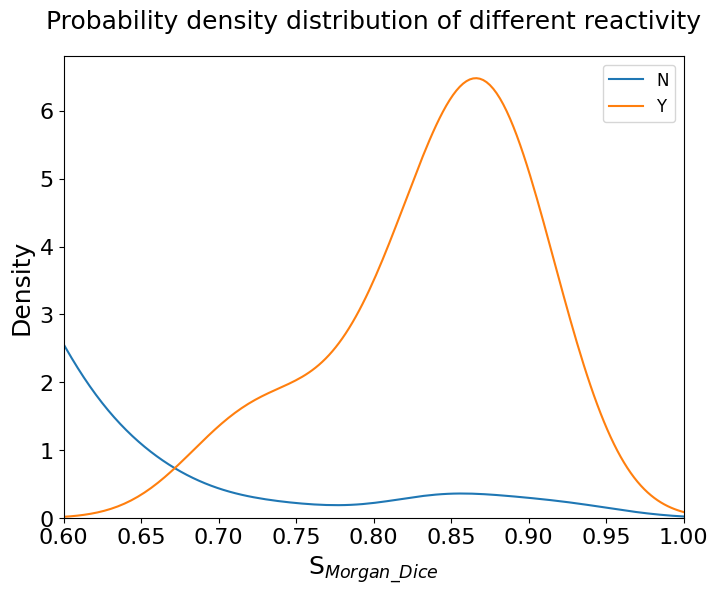

In [18]:
import seaborn as sns
df_Y = data_test[data_test['label_x'] == 'Y'].reset_index(drop=True)
df_N = data_test[data_test['label_x'] == 'N'].reset_index(drop=True)
sns.kdeplot(data=df_N['max_ecfp_sim'].to_numpy(), label='N')
sns.kdeplot(data=df_Y['max_ecfp_sim'].to_numpy(), label='Y')
plt.xlabel('S$_{Morgan\_Dice}$',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Probability density distribution of different reactivity',fontsize=18,pad=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend()
plt.xlim(0.6, 1)
plt.savefig('Figure 6b(YN).png',dpi=600)

In [16]:
#data_generate=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/generate_model/new_rxn_df_subset.csv')
data_generate=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/generate_model/new_rxn_df.csv')

In [15]:
data_generate['ecfp']=data_generate['rxn_smiles'].progress_apply(lambda x: get_rxn_ecfp(x))

100%|██████████| 90048/90048 [00:22<00:00, 4025.21it/s]


In [16]:
data_generate['max_ecfp_sim']=data_generate['ecfp'].progress_apply(lambda x: get_max_ecfp_dice_similarity(x,emb_list))

100%|██████████| 90048/90048 [4:53:45<00:00,  5.11it/s]  


In [17]:
data_generate['max_ecfp_sim'].describe()

count    90048.000000
mean         0.544307
std          0.072324
min          0.324927
25%          0.492791
50%          0.534250
75%          0.586694
max          1.000000
Name: max_ecfp_sim, dtype: float64

In [18]:
data_generate.to_pickle('new_generated_suzuki_with_ecfp_sim_true_structure.pkl')

In [19]:
data_generate.to_csv('new_generated_suzuki_with_ecfp_sim_true_structure.csv')

In [32]:
data_generate=pd.read_pickle('new_generated_suzuki_with_ecfp_sim_true_structure.pkl')

In [33]:
data_generate.head(1)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0,rxn_smiles,ecfp,max_ecfp_sim
0,0,Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.0


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

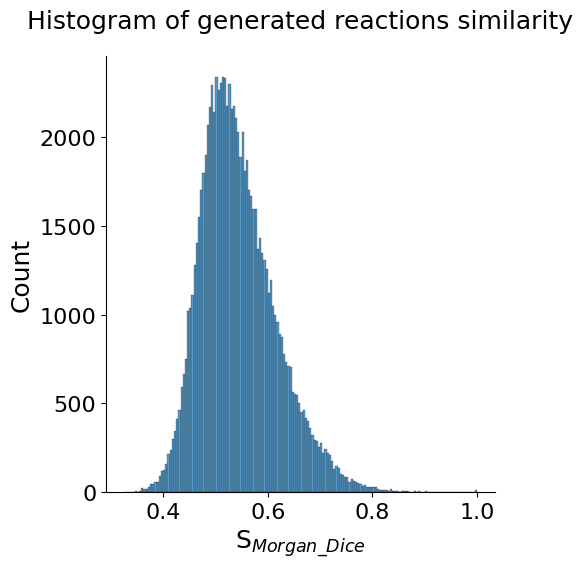

In [39]:
sns.displot(data=data_generate['max_ecfp_sim'].to_numpy())
plt.xlabel('S$_{Morgan\_Dice}$',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Histogram of generated reactions similarity',fontsize=18,pad=20)
plt.savefig('Figure 4b(Morgan).jpg',dpi=600,bbox_inches='tight')

Text(0.5, 1.0, 'pdf of generated reactions similarity(using ecfp)')

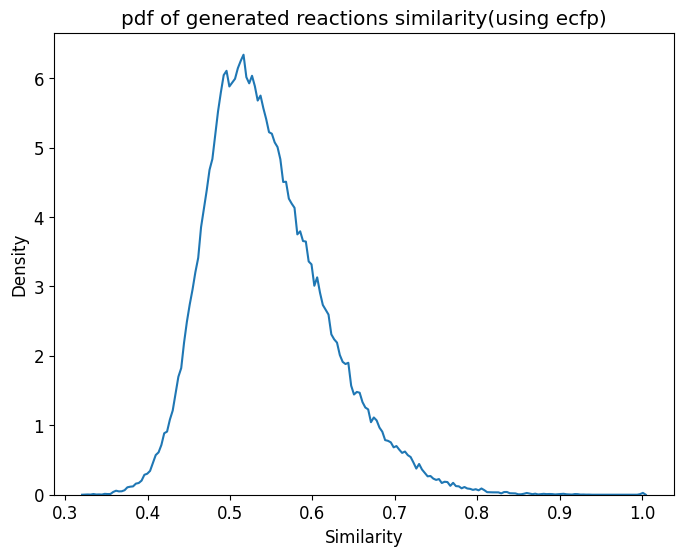

In [21]:
sns.kdeplot(data=data_generate['max_ecfp_sim'].to_numpy(), bw_adjust=.2)
plt.xlabel('Similarity')
plt.title('pdf of generated reactions similarity(using ecfp)')